# LCZ Classification with landcover + building data and spectral indices

This chapter uses previously prepared landcover and building data and combines those with remotely sensed spectra indices

*landcover_buildings_analysis* processes landcover and building data

*extract_spectral_indices.ipynb* harvests the spectral indices used in this chapter

**Notebook dependencies**

In [1]:
# library import
# library import
import pandas as pd 
import geopandas as gpd
import pathlib
import numpy as np
import shapely

import rasterio
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
#from rasterio.enums import Resampling
from numpy import int16

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

In [23]:
# defining relative paths
NOTEBOOK_DIRECTORY = pathlib.Path().resolve()

_2014_DIRECTORY = NOTEBOOK_DIRECTORY / "output" / "2014"
_2022_DIRECTORY = NOTEBOOK_DIRECTORY / "output" / "2022"


_2014_CLEANED_DIRECTORY = _2014_DIRECTORY / "spectral_indices" / "cleaned"
_2022_CLEANED_DIRECTORY = _2022_DIRECTORY / "spectral_indices" / "cleaned"


_2014_OUTPUT_DIRECTORY = _2014_DIRECTORY / "reclassified"
_2022_OUTPUT_DIRECTORY = _2022_DIRECTORY / "reclassified"

## Helper functions

In [3]:
def export_raster(DIRECTORY, name, raster):
    # Round only valid values
    raster = np.where(raster == -9999.0, -9999.0, np.round(raster, 1))

    with rasterio.open(
        DIRECTORY / name,
        "w",
        driver="GTiff",
        height=base_raster.shape[0],
        width=base_raster.shape[1],
        count=1,
        dtype=rasterio.float32,
        crs='EPSG:3301',
        transform=base_raster.transform,
        nodata=-9999.0,
    ) as dst:
        dst.write(raster.astype(np.float32), 1)

In [4]:
def load_rasters(directory, raster_paths):
    raster_arrays = {}
    for key, rel_path in raster_paths.items():
        with rasterio.open(directory / rel_path) as src:
            raster_arrays[key] = src.read(1)
    return raster_arrays

In [19]:
# Define the reclassification logic
def reclassify_built_lcz(built_fraction, building_height):
    
    """Reclassify LCZ based on given conditions"""
    
    reclassified_raster = np.full_like(built_fraction, -9999.0)  # Initialize with NoData values

    ## Apply classification conditions ##

    # compact classes 1-3 #

    # highrise
    reclassified_raster[((built_fraction >= 41) & (built_fraction <= 100)) & (building_height > 25)] = 1  # LCZ 1
    # midrise
    reclassified_raster[((built_fraction >= 41) & (built_fraction <= 100)) & ((building_height >= 10) & (building_height <= 25))] = 2  # LCZ 2
    # lowrise
    reclassified_raster[((built_fraction >= 41) & (built_fraction <= 100)) & ((building_height >= 2) & (building_height <= 9))] = 3  # LCZ 3

    # open classes 4-6 #

    # highrise
    reclassified_raster[((built_fraction >= 20) & (built_fraction <= 40)) & (building_height > 25)] = 4  # LCZ 4
    # midrise
    reclassified_raster[((built_fraction >= 20) & (built_fraction <= 40)) & ((building_height >= 10) & (building_height <= 25))] = 5  # LCZ 5
    # lowrise
    reclassified_raster[((built_fraction >= 20) & (built_fraction <= 40)) & ((building_height >= 2) & (building_height <= 9))] = 6  # LCZ 5

    # special classes 8-10 #
    
    # sparsley built
    reclassified_raster[((built_fraction >= 0) & (built_fraction <= 19)) & ((building_height >= 2) & (building_height <= 9))] = 9  # LCZ 9



    
    #reclassified_bf_raster[((built_fraction >= 0) & (built_fraction < 20))] = 22 # lower than LCZ4, 5, 6

    #reclassified_bh_raster[(building_height > 25)] = 14 # LCZ1 + 4
    #reclassified_bh_raster[((building_height > 10) & (building_height <= 25))] = 25 # LCZ2 + 5
    #reclassified_bh_raster[((building_height >= 3) & (building_height <= 10))] = 36 # LCZ3 + 6
    #reclassified_bh_raster[((building_height >= 0) & (building_height < 3))] = 362 # lower than LCZ3 + 6

    #reclassified_built_raster[((built_fraction > 40) & (built_fraction <= 70)) & (building_height > 25)] = 1 # LCZ1
    #reclassified_built_raster[((built_fraction > 40) & (built_fraction <= 70)) & ((building_height > 10) & (building_height <= 25))] = 2 # LCZ2
    #reclassified_built_raster[((built_fraction > 40) & (built_fraction <= 70)) & ((building_height >= 3) & (building_height <= 10))] = 3 # LCZ3
    #reclassified_built_raster[((built_fraction >= 20) & (built_fraction <= 40)) & (building_height > 25)] = 4 # LCZ4
    #reclassified_built_raster[((built_fraction >= 20) & (built_fraction <= 40)) & ((building_height > 10) & (building_height <= 25))] = 5 # LCZ5
    #reclassified_built_raster[((built_fraction >= 20) & (built_fraction <= 40)) & ((building_height >= 3) & (building_height <= 10))] = 6 # LCZ6
    
    #reclassified_raster[((built_fraction >= 0) & (built_fraction <= 30)) & (building_height <= 9)] = 3  # LCZ1
    #reclassified_raster[((built_fraction >= 31) & (built_fraction <= 70)) & ((building_height <= 9) & (building_height <= 9))] = 3  # LCZ1
    #reclassified_raster[(landcover == 2) & ((built_fraction > 40) & (built_fraction <= 70)) & ((NDVI >= -1) & (NDVI <= 0.1)) & ((building_height >= 10) & (building_height < 25))] = 2  # LCZ2
    #reclassified_raster[(landcover == 2) & ((built_fraction > 40) & (built_fraction <= 70)) & ((NDVI >= -1) & (NDVI <= 0.1)) & ((building_height >= 3) & (building_height < 10))]= 3  # LCZ3
    #reclassified_raster[(landcover == 1) & ((built_fraction > 20) & (built_fraction <= 40)) & ((NDVI > 0.1) & (NDVI <= 0.5)) & (building_height >= 25)] = 4  # LCZ4
    #reclassified_raster[(landcover == 1) & ((built_fraction > 20) & (built_fraction <= 40)) & ((NDVI > 0.1) & (NDVI <= 0.5)) & ((building_height >= 10) & (building_height < 25))] = 5  # LCZ5
    #reclassified_raster[(landcover == 1) & ((built_fraction > 20) & (built_fraction <= 40)) & ((NDVI > 0.1) & (NDVI <= 0.5)) & ((building_height >= 3) & (building_height < 10))] = 6  # LCZ6
    #reclassified_raster[(landcover == 2) & ((built_fraction >= 60) & (built_fraction <= 100)) & ((NDVI >= -1) & (NDVI <= 0.1)) & ((building_height >= 2) & (building_height <= 4))] = 7  # LCZ7
    #reclassified_raster[(landcover == 2) & ((built_fraction > 30) & (built_fraction <= 50)) & ((NDVI >= -1) & (NDVI <= 0.1)) & ((building_height >= 3) & (building_height < 10))] = 8  # LCZ8
    #reclassified_raster[(landcover == 1) & ((built_fraction >= 10) & (built_fraction <= 20)) & ((NDVI > 0.1) & (NDVI <= 0.5)) & ((building_height >= 3) & (building_height < 10))] = 9  # LCZ9
    #reclassified_raster[(landcover == 2) & ((built_fraction > 20) & (built_fraction <= 30)) & ((NDVI >= -1) & (NDVI <= 0.1)) & ((building_height >= 5) & (building_height <= 15))] = 10 # LCZ10

    # Natural classes (no query for buildings because landcover classes 3-6 do not conatain buildings, compare accuracy assesment)
    #reclassified_raster[(landcover == 3) & ((NDVI > 0.5) & (NDVI <= 1))] = 11 # LCZA
    #reclassified_raster[(landcover == 3) & ((NDVI >= 0.5) & (NDVI <= 1))] = 12 # LCZB
    #reclassified_raster[(landcover == 3) & ((NDVI > 0.5) & (NDVI <= 1))] = 13 # LCZC
    #reclassified_raster[(landcover == 4) & ((NDVI > 0.1) & (NDVI <= 0.5))] = 14 # LCZD
    #reclassified_raster[(landcover == 6) & ((NDVI >= -1) & (NDVI <= 0.1))] = 15 # LCZE
    #reclassified_raster[(landcover == 4) & ((NDVI >= -1) & (NDVI <= 0.1))] = 16 # LCZF
    #reclassified_raster[(landcover == 5)] = 17 # LCZG
    

    return reclassified_raster

## Importing rasters

In [5]:
base_raster = rasterio.open('/Users/moritzmuhlbauer/Master Thesis/data/baseline_raster.tif')

In [6]:
paths_2014 = {
    'bh': Path("rasterized/mean_building_height.tif"),
    'bf': Path("rasterized/built_fraction.tif"),
    'landcover': Path("rasterized/landcover.tif"),
    'NDVI': Path("spectral_indices/NDVI_2014.tif"),
    'NDBI': Path("spectral_indices/NDBI_2014.tif")
}

paths_2022 = {
    'bh': Path("rasterized/mean_building_height.tif"),
    'bf': Path("rasterized/built_fraction.tif"),
    'landcover': Path("rasterized/landcover.tif"),
    'NDVI': Path("spectral_indices/NDVI_2022.tif"),
    'NDBI': Path("spectral_indices/NDBI_2022.tif")
}

# Load rasters into dictionaries of NumPy arrays
rasters_2014 = load_rasters(_2014_DIRECTORY, paths_2014)
rasters_2022 = load_rasters(_2022_DIRECTORY, paths_2022)

# Access like:
NDVI_2014 = rasters_2014['NDVI']
landcover_2022 = rasters_2022['landcover']


## Reclassify to LCZ

In [25]:
# performing built lcz reclassification for 2014
reclassified_built_lcz_2014 = reclassify_built_lcz(rasters_2014['bf'], rasters_2014['bh'])

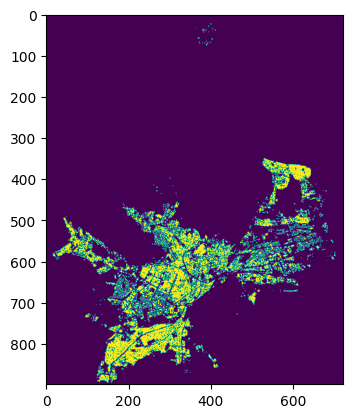

In [26]:
plt.imshow(reclassified_built_lcz_2014)

In [30]:
export_raster(_2014_OUTPUT_DIRECTORY, 'built_lcz_reclassified_2014', reclassified_built_lcz_2014)

---

In [28]:
# performing built lcz reclassification for 2022
reclassified_built_lcz_2022 = reclassify_built_lcz(rasters_2022['bf'], rasters_2022['bh'])

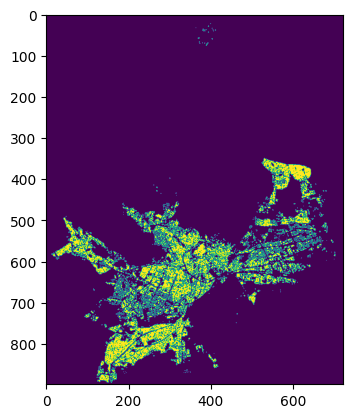

In [29]:
plt.imshow(reclassified_built_lcz_2022)

In [31]:
export_raster(_2022_OUTPUT_DIRECTORY, 'built_lcz_reclassified_2022', reclassified_built_lcz_2022)

## Cleaning NDVI and NDBI

In [7]:
# water mask for both years
water_mask_2014 = rasters_2014['landcover'] != 5
water_mask_2022 = rasters_2022['landcover'] != 5

In [8]:
# removing water from NDBI
NDBI_2014_wo_water = np.where(water_mask_2014, rasters_2014['NDBI'], -9999.0)
NDBI_2022_wo_water = np.where(water_mask_2022, rasters_2022['NDBI'], -9999.0)

# exporting clean NDBI
export_raster(_2014_CLEANED_DIRECTORY, 'NDBI_cleaned_2014.tif', NDBI_2014_wo_water)
export_raster(_2022_CLEANED_DIRECTORY, 'NDBI_cleaned_2022.tif', NDBI_2022_wo_water)

In [9]:
# removing water from NDVI
NDVI_2014_wo_water = np.where(water_mask_2014, rasters_2014['NDVI'], -9999.0)
NDVI_2022_wo_water = np.where(water_mask_2022, rasters_2022['NDVI'], -9999.0)

# exporting clean NDVI
export_raster(_2014_CLEANED_DIRECTORY, 'NDVI_cleaned_2014.tif', NDVI_2014_wo_water)
export_raster(_2022_CLEANED_DIRECTORY, 'NDVI_cleaned_2022.tif', NDVI_2022_wo_water)

## NDBI over artifical surface

In [23]:
# extract artifical with and without vegetation and transportation
artifical_surface_2014 = (rasters_2014['landcover'] == 1) | (rasters_2014['landcover'] == 2) | (rasters_2014['landcover'] == 6)
artifical_surface_2022 = (rasters_2022['landcover'] == 1) | (rasters_2022['landcover'] == 2) | (rasters_2022['landcover'] == 6)

# extracting NDBI over artifical landcover
NDBI_as_2014 = np.where(artifical_surface_2014, NDBI_2014_wo_water, -9999.0)
NDBI_as_2022 = np.where(artifical_surface_2022, NDBI_2022_wo_water, -9999.0)

# exporting
export_raster(_2014_DIRECTORY, 'NDBI_as_2014.tif', NDBI_as_2014)
export_raster(_2022_DIRECTORY, 'NDBI_as_2022.tif', NDBI_as_2022)

## NDBI over built up landcover

In [12]:
# extracting NDBI over built up areas
NDBI_built_up_2014 = np.where(rasters_2014['bf'], NDBI_2014_wo_water, -9999.0)
NDBI_built_up_2022 = np.where(rasters_2022['bf'], NDBI_2022_wo_water, -9999.0)

# exporting 
export_raster(_2014_DIRECTORY, 'NDBI_built_up_2014.tif', NDBI_built_up_2014)
export_raster(_2022_DIRECTORY, 'NDBI_built_up_2022.tif', NDBI_built_up_2022)

## NDVI over natural landcover

In [13]:
# extracting natural landcovers
natural_2014 = (rasters_2014['landcover'] == 3) | (rasters_2014['landcover'] == 4)
natural_2022 = (rasters_2022['landcover'] == 3) | (rasters_2022['landcover'] == 4)

# extracting NDVI over landcovers
NDVI_natural_2014 = np.where(natural_2014, NDVI_2014_wo_water, -9999.0)
NDVI_natural_2022 = np.where(natural_2022, NDVI_2022_wo_water, -9999.0)

# exporting
export_raster(_2014_DIRECTORY, 'NDVI_natural_2014.tif', NDVI_natural_2014)
export_raster(_2022_DIRECTORY, 'NDVI_natural_2022.tif', NDVI_natural_2022)

## Difference between 2014 and 2022

**NDVI**

In [7]:
# masking where land cover is NOT water (raster code = 5)
water_mask_14_22 = (rasters_2022['landcover'] != 5) & (rasters_2014['landcover'] != 5)

In [11]:
# NDVI difference
NDVI_diff = np.where(water_mask_14_22, rasters_2022['NDVI'] - rasters_2014['NDVI'], -9999.0)

In [8]:
NDBI_diff = np.where(water_mask_14_22, rasters_2022['NDBI'] - rasters_2014['NDBI'], -9999.0)

**NDBI**

In [21]:
# masking where both rasters have NA
mask_valid = (NDBI_built_up_2014 != -9999.0) | (NDBI_built_up_2022 != -9999.0)
    
# masking where both rasters had 0 
NDBI_diff = np.where(mask_valid, NDBI_built_up_2022 - NDBI_built_up_2014, -9999.0)

export_raster(NOTEBOOK_DIRECTORY, 'NDBI_diff.tif', NDBI_diff)

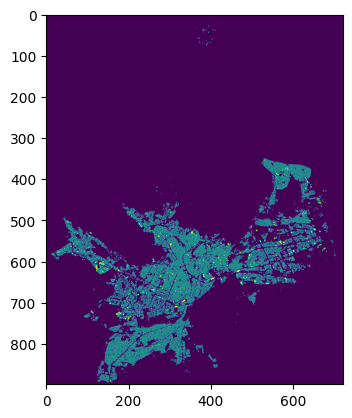

In [22]:
plt.imshow(NDBI_diff)

In [12]:
export_raster('NDVI_difference.tif', NDVI_diff)
export_raster('NDBI_difference.tif', NDBI_diff)

## Test

In [39]:
# Define the reclassification logic
def reclassify_lcz(landcover, NDVI):
    
    # Read raster data into NumPy arrays
    #landcover_array = landcover.read(1)
    #built_fraction_array = built_fraction.read(1)
    #NDVI_array = NDVI.read(1)
    
    # Ensure data is in a NumPy array format
    #landcover = np.array(landcover_array)
    #built_fraction = np.array(built_fraction_array)
    #NDVI = np.array(NDVI_array)
    
    """Reclassify LCZ based on given conditions."""

    natural_mask = (landcover == 3) | (landcover == 4)
    ndvi_natural = np.where(natural_mask, NDVI, np.nan)

    
    #natural_classes = np.full_like(landcover, -2)  # Initialize with NoData values
    #reclassified_bh_raster = np.full_like(landcover, -2)
    #reclassified_built_raster = np.full_like(landcover, -2)
    #natural_classes[(NDVI >= 0.6) & (landcover == 3)] = 1
    #natural_classes[((NDVI > 0.2) & (NDVI <= 0.6)) & ((landcover == 1) | (landcover == 2) | (landcover == 3))] = 2
    #natural_classes[((NDVI <= 0.2) & (landcover != 5))] = 3
    

    # Built classes & (building_height > 25)]
    #reclassified_bf_raster[((built_fraction > 40) & (built_fraction <= 70))]  = 1  # LCZ1, 2, 3
    #reclassified_bf_raster[((built_fraction >= 20) & (built_fraction <= 40))] = 2  # LCZ4, 5, 6
    #reclassified_bf_raster[((built_fraction > 70) & (built_fraction <= 100))] = 11  # higher than LCZ1, 2, 3
    #reclassified_bf_raster[((built_fraction >= 0) & (built_fraction < 20))] = 22 # lower than LCZ4, 5, 6

    #reclassified_bh_raster[(building_height > 25)] = 14 # LCZ1 + 4
    #reclassified_bh_raster[((building_height > 10) & (building_height <= 25))] = 25 # LCZ2 + 5
    #reclassified_bh_raster[((building_height >= 3) & (building_height <= 10))] = 36 # LCZ3 + 6
    #reclassified_bh_raster[((building_height >= 0) & (building_height < 3))] = 362 # lower than LCZ3 + 6

    #reclassified_built_raster[((built_fraction > 40) & (built_fraction <= 70)) & (building_height > 25)] = 1 # LCZ1
    #reclassified_built_raster[((built_fraction > 40) & (built_fraction <= 70)) & ((building_height > 10) & (building_height <= 25))] = 2 # LCZ2
    #reclassified_built_raster[((built_fraction > 40) & (built_fraction <= 70)) & ((building_height >= 3) & (building_height <= 10))] = 3 # LCZ3
    #reclassified_built_raster[((built_fraction >= 20) & (built_fraction <= 40)) & (building_height > 25)] = 4 # LCZ4
    #reclassified_built_raster[((built_fraction >= 20) & (built_fraction <= 40)) & ((building_height > 10) & (building_height <= 25))] = 5 # LCZ5
    #reclassified_built_raster[((built_fraction >= 20) & (built_fraction <= 40)) & ((building_height >= 3) & (building_height <= 10))] = 6 # LCZ6
    
    #reclassified_raster[((built_fraction >= 0) & (built_fraction <= 30)) & (building_height <= 9)] = 3  # LCZ1
    #reclassified_raster[((built_fraction >= 31) & (built_fraction <= 70)) & ((building_height <= 9) & (building_height <= 9))] = 3  # LCZ1
    #reclassified_raster[(landcover == 2) & ((built_fraction > 40) & (built_fraction <= 70)) & ((NDVI >= -1) & (NDVI <= 0.1)) & ((building_height >= 10) & (building_height < 25))] = 2  # LCZ2
    #reclassified_raster[(landcover == 2) & ((built_fraction > 40) & (built_fraction <= 70)) & ((NDVI >= -1) & (NDVI <= 0.1)) & ((building_height >= 3) & (building_height < 10))]= 3  # LCZ3
    #reclassified_raster[(landcover == 1) & ((built_fraction > 20) & (built_fraction <= 40)) & ((NDVI > 0.1) & (NDVI <= 0.5)) & (building_height >= 25)] = 4  # LCZ4
    #reclassified_raster[(landcover == 1) & ((built_fraction > 20) & (built_fraction <= 40)) & ((NDVI > 0.1) & (NDVI <= 0.5)) & ((building_height >= 10) & (building_height < 25))] = 5  # LCZ5
    #reclassified_raster[(landcover == 1) & ((built_fraction > 20) & (built_fraction <= 40)) & ((NDVI > 0.1) & (NDVI <= 0.5)) & ((building_height >= 3) & (building_height < 10))] = 6  # LCZ6
    #reclassified_raster[(landcover == 2) & ((built_fraction >= 60) & (built_fraction <= 100)) & ((NDVI >= -1) & (NDVI <= 0.1)) & ((building_height >= 2) & (building_height <= 4))] = 7  # LCZ7
    #reclassified_raster[(landcover == 2) & ((built_fraction > 30) & (built_fraction <= 50)) & ((NDVI >= -1) & (NDVI <= 0.1)) & ((building_height >= 3) & (building_height < 10))] = 8  # LCZ8
    #reclassified_raster[(landcover == 1) & ((built_fraction >= 10) & (built_fraction <= 20)) & ((NDVI > 0.1) & (NDVI <= 0.5)) & ((building_height >= 3) & (building_height < 10))] = 9  # LCZ9
    #reclassified_raster[(landcover == 2) & ((built_fraction > 20) & (built_fraction <= 30)) & ((NDVI >= -1) & (NDVI <= 0.1)) & ((building_height >= 5) & (building_height <= 15))] = 10 # LCZ10

    # Natural classes (no query for buildings because landcover classes 3-6 do not conatain buildings, compare accuracy assesment)
    #reclassified_raster[(landcover == 3) & ((NDVI > 0.5) & (NDVI <= 1))] = 11 # LCZA
    #reclassified_raster[(landcover == 3) & ((NDVI >= 0.5) & (NDVI <= 1))] = 12 # LCZB
    #reclassified_raster[(landcover == 3) & ((NDVI > 0.5) & (NDVI <= 1))] = 13 # LCZC
    #reclassified_raster[(landcover == 4) & ((NDVI > 0.1) & (NDVI <= 0.5))] = 14 # LCZD
    #reclassified_raster[(landcover == 6) & ((NDVI >= -1) & (NDVI <= 0.1))] = 15 # LCZE
    #reclassified_raster[(landcover == 4) & ((NDVI >= -1) & (NDVI <= 0.1))] = 16 # LCZF
    #reclassified_raster[(landcover == 5)] = 17 # LCZG
    

    return ndvi_natural

# Perform reclassification
natural_classes = reclassify_lcz(landcover_2014, NDVI_2014)

In [ ]:
# Save the new raster using rasterio
with rasterio.open(
    TEST_DIRECTORY / "reclassified_bh.tif",
    "w",  # Write mode
    driver="GTiff",
    height=reclassified_bh.shape[0],
    width=reclassified_bh.shape[1],
    count=1,  # Single-band raster
    dtype=rasterio.int16,  # Match data type
    crs='EPSG:3301',  # Copy CRS from the original raster
    transform=base_raster.transform,  # Copy spatial transform
    nodata=-2,  # Assign NoData value
) as dst:
    dst.write(reclassified_bh, 1)  # Write data to band 1

# Save the new raster using rasterio
with rasterio.open(
    TEST_DIRECTORY / "reclassified_built.tif",
    "w",  # Write mode
    driver="GTiff",
    height=reclassified_built.shape[0],
    width=reclassified_built.shape[1],
    count=1,  # Single-band raster
    dtype=rasterio.int16,  # Match data type
    crs='EPSG:3301',  # Copy CRS from the original raster
    transform=base_raster.transform,  # Copy spatial transform
    nodata=-2,  # Assign NoData value
) as dst:
    dst.write(reclassified_built, 1)  # Write data to band 1